In [70]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
from scipy.special import softmax
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [22]:
adata = sc.read_h5ad('/raid/brunopsz/Data/DLLS_PROJECT/train/cell_data.h5ad')
adata

AnnData object with n_obs × n_vars = 236791 × 40
    obs: 'image', 'sample_id', 'ObjectNumber', 'Pos_X', 'Pos_Y', 'area', 'major_axis_length', 'minor_axis_length', 'eccentricity', 'width_px', 'height_px', 'acquisition_id', 'SlideId', 'Study', 'Box.Description', 'Position', 'SampleId', 'Indication', 'BatchId', 'SubBatchId', 'ROI', 'ROIonSlide', 'includeImage', 'flag_no_cells', 'flag_no_ROI', 'flag_total_area', 'flag_percent_covered', 'small_cell', 'celltypes', 'flag_tumor', 'PD1_pos', 'Ki67_pos', 'cleavedPARP_pos', 'GrzB_pos', 'tumor_patches', 'distToCells', 'CD20_patches', 'Batch', 'cell_labels'
    var: 'channel', 'use_channel', 'marker'
    layers: 'counts', 'exprs'

<AxesSubplot: title={'center': 'Cell type composition'}>

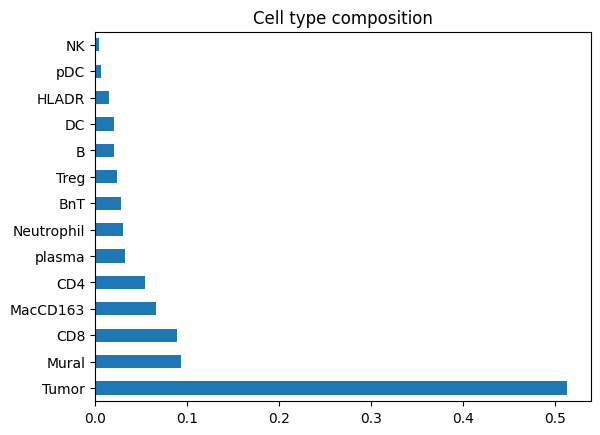

In [23]:
adata.obs['cell_labels'].value_counts(normalize=True).plot(kind='barh', title='Cell type composition')

In [24]:
adata.obsm['X_exprs'] = adata.layers['exprs']
adata

AnnData object with n_obs × n_vars = 236791 × 40
    obs: 'image', 'sample_id', 'ObjectNumber', 'Pos_X', 'Pos_Y', 'area', 'major_axis_length', 'minor_axis_length', 'eccentricity', 'width_px', 'height_px', 'acquisition_id', 'SlideId', 'Study', 'Box.Description', 'Position', 'SampleId', 'Indication', 'BatchId', 'SubBatchId', 'ROI', 'ROIonSlide', 'includeImage', 'flag_no_cells', 'flag_no_ROI', 'flag_total_area', 'flag_percent_covered', 'small_cell', 'celltypes', 'flag_tumor', 'PD1_pos', 'Ki67_pos', 'cleavedPARP_pos', 'GrzB_pos', 'tumor_patches', 'distToCells', 'CD20_patches', 'Batch', 'cell_labels'
    var: 'channel', 'use_channel', 'marker'
    obsm: 'X_exprs'
    layers: 'counts', 'exprs'

/home/brunopsz/Env/my_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


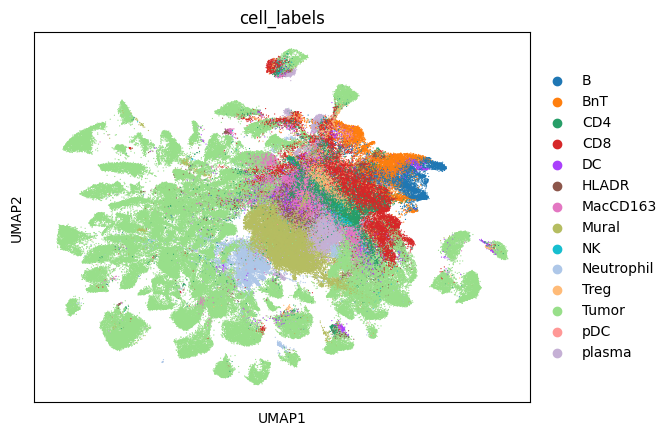

In [25]:
sc.pp.neighbors(adata, use_rep='X_exprs')
sc.tl.umap(adata)
sc.pl.umap(
    adata,
    color=["cell_labels"],
    size=3
)

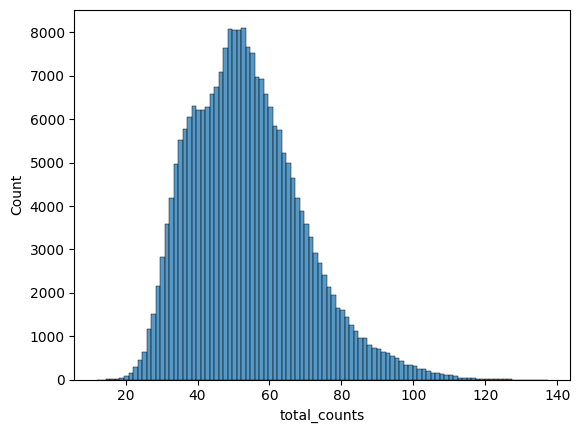

In [26]:
adata.obs['total_counts'] = adata.layers['exprs'].sum(axis=1)

p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False)

In [27]:
adata.layers['exprs'].var(axis=0)

array([0.11781819, 0.97307184, 0.40366449, 0.60623521, 0.29032015,
       1.86709384, 0.34815958, 1.90792766, 0.49226651, 0.68959419,
       0.68045351, 0.58945701, 0.71002854, 0.34384454, 0.70295762,
       0.08513978, 0.62974337, 0.13528121, 0.44040303, 0.69766854,
       0.39432378, 0.44130367, 0.52864032, 0.79604536, 0.24024655,
       0.29826498, 1.07912999, 1.31095891, 0.5828141 , 2.16509058,
       0.41423096, 0.64970786, 0.48513389, 0.75132637, 2.23353438,
       0.30022553, 0.4814998 , 0.08003225, 0.50588685, 0.51060286])

Normalization

In [16]:
sc.pp.normalize_total(adata, layer='exprs')
sc.pp.log1p(adata, layer='exprs')
sc.pp.scale(adata, layer='exprs')

In [28]:
adata.layers['exprs'].var(axis=0)

array([0.11781819, 0.97307184, 0.40366449, 0.60623521, 0.29032015,
       1.86709384, 0.34815958, 1.90792766, 0.49226651, 0.68959419,
       0.68045351, 0.58945701, 0.71002854, 0.34384454, 0.70295762,
       0.08513978, 0.62974337, 0.13528121, 0.44040303, 0.69766854,
       0.39432378, 0.44130367, 0.52864032, 0.79604536, 0.24024655,
       0.29826498, 1.07912999, 1.31095891, 0.5828141 , 2.16509058,
       0.41423096, 0.64970786, 0.48513389, 0.75132637, 2.23353438,
       0.30022553, 0.4814998 , 0.08003225, 0.50588685, 0.51060286])

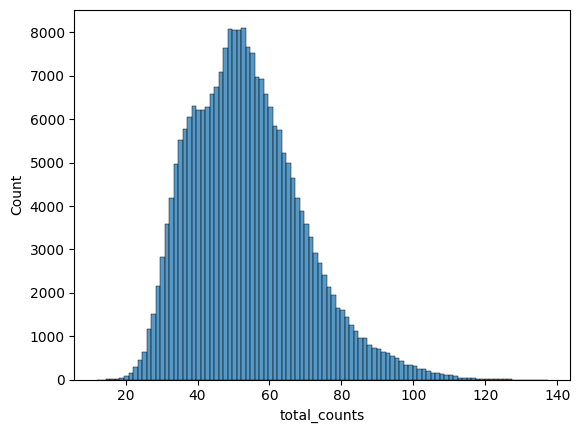

In [29]:
adata.obs['total_counts'] = adata.layers['exprs'].sum(axis=1)

p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False)

In [96]:
class MultipleLogRegression:
    
    def __init__(self, learning_rate=0.1, n_iters=1000):
        self.lr = learning_rate
        self.iters = n_iters
        self.W = None
        
    def fit(self,X, y, mu):
        acc = []
        # y = np.array(y)
        ones = np.ones(X.shape[0])
        features = np.c_[ones, X]
        # onehot_encoder = OneHotEncoder(sparse=False)
        # y_encode = onehot_encoder.fit_transform(y.reshape(-1,1))
        self.W = np.zeros((features.shape[1], y.shape[1]))
        samples = X.shape[0]
        
        with tqdm(range(self.iters), desc='Iteration', position=0) as t:
            for _ in t:
                Z = -features@self.W
                prob_y = softmax(Z, axis=1)
                error = y - prob_y
                acc_it = np.sum(np.argmax(y, axis=1) == np.argmax(prob_y, axis=1))/len(y)
                dW = 1/samples * (features.T @ error) + 2 * mu * self.W
                self.W -= self.lr * dW
                t.set_postfix(accuracy = round(acc_it, 2))
                acc.append(acc_it)
        return acc
            
    def predict(self, X):
        ones=np.ones(X.shape[0])
        features=np.c_[ones,X]
        Z=-features@self.W
        y=softmax(Z,axis=1)
        return np.argmax(y,axis=1)

In [97]:
X = adata.layers['exprs']
y = adata.obs['cell_labels']

onehot_encoder = OneHotEncoder(sparse=False)
y_encode = onehot_encoder.fit_transform(np.array(y).reshape(-1,1))

X_train, X_val, y_encode_train, y_encode_val = train_test_split(X, y_encode, test_size=0.2, random_state=0, shuffle=True)
print(X_train.shape)
print(y_encode_train.shape)

(189432, 40)
(189432, 14)


In [98]:
mlr_model = MultipleLogRegression(n_iters=500)
accuracy_train = mlr_model.fit(X_train, y_encode_train, 0.0)

Iteration: 100%|██████████| 500/500 [01:18<00:00,  6.35it/s, accuracy=0.89]


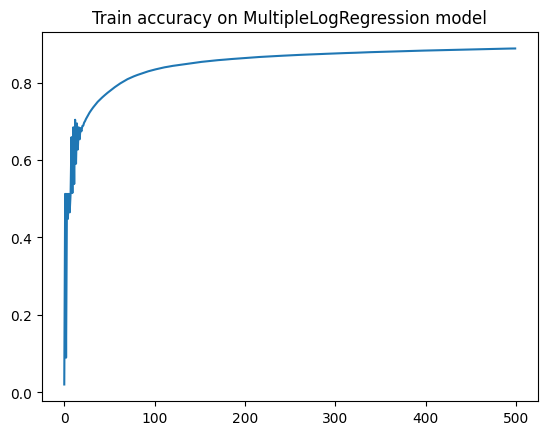

In [99]:
plt.title('Train accuracy on MultipleLogRegression model')
plt.plot(accuracy_train)

In [100]:
y_pred = mlr_model.predict(X_val)
accuracy_val = np.sum(y_pred == np.argmax(y_encode_val, axis=1))/len(y_pred)
print(f'Validation accuracy: {accuracy_val:.2f}')  

Validation accuracy: 0.89
